In [1]:
from dask.distributed import Client, SSHCluster

machine1 = '10.67.22.152'
machine2 = '10.67.22.250'
#machine3 = '10.67.22.254'

In [2]:
import os
import dask
import ast
import json
from dask import delayed, compute
import io
from dask.distributed import LocalCluster
from dask import delayed
import dask.array as da
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import dask.bag as db
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
import dask.dataframe as ddf
import csv
import numpy as np

In [3]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

In [4]:
def load_json_data(filename):
    
    with open(os.path.join(folder_path, filename), 'r') as file:
        json_data = json.load(file)
        
    return json_data

def extract_titles(record):
    
    ID = record['paper_id']
    title = record['metadata']['title']
    title_tokens = word_tokenize(record['metadata']['title'])
    title_tokens_clean = [word.lower() for word in title_tokens\
                          if not word.lower() in stopwords.words('english') + ['use','used']\
                         and word.isalpha()] 
    
    return{'ID': ID,
          'title': title,
          'title_tokens': title_tokens_clean}

# Calculate the embedding matrix for a line
def calculate_embedding_matrix(line):
    keys = line
    values = [model.get(key) for key in keys if model.get(key)]
    matrix = [vector  for vector in values]
    return matrix

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    line_count = 0  # Track the number of lines read
    for line in fin:
        if line_count >= 1000:
            break  # Exit the loop after 100000 lines
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
        line_count += 1
    fin.close()  # Close the file after reading
    return data

def max_finder(embed):
    
    max_sim = 0
    max_indx = 0
    
    for i in range(len(embedding_matrices)):
        
        sim = calculate_similarity(embed , embedding_matrices[i])[0][0]
        
        if sim > max_sim and sim < 0.99:
            
            max_sim = sim
            max_indx = i
            
    return (max_sim , max_indx)


# Calculate cosine similarity between two lines
def calculate_similarity(line1, line2):
    
    similarity = cosine_similarity(line1 , line2)
    return similarity

In [5]:
folder_path = '/mnt/covid/data/papers1'
file_list = os.listdir(folder_path)

# Create a Dask Bag to store the imported data
bag = db.from_sequence(file_list).map(load_json_data)

titles = bag.map(extract_titles)
model = load_vectors('wiki.en.vec')

df_title = titles.to_dataframe(meta=pd.DataFrame(columns = ['ID', 'title', 'title_tokens' ])).repartition(8)    
df_title.persist()   
df_title['embedding matrix'] = df_title['title_tokens'].map(calculate_embedding_matrix)   
df_title.persist()   

,ID,title,title_tokens,embedding matrix
npartitions=8,,,,
,object,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [6]:
df_title = df_title.loc[~(df_title['title_tokens'].map(lambda x: x == []))]
df_title = df_title.loc[~(df_title['embedding matrix'].map(lambda x: x == []))]
df_title.persist()
df_title['embedding matrix'] = df_title['embedding matrix'].apply(lambda x: [np.mean(x , axis = 0)] , meta = ('x' , 'object'))
df_title.persist()
embedding_matrices = df_title['embedding matrix'].compute().tolist()
df = df_title.compute()
df = df.reset_index( drop=True)

In [7]:
npartitions = [1 ,2,  4 , 8 , 16,  32 , 64 , 128, 256]

In [8]:
nworkers = [1 , 2 , 4 , 8 , 14]

In [9]:
def time_task4(npartitions):
    
    i = time.time()
    
    ddf = dd.from_pandas(df, npartitions)
    result = ddf['embedding matrix'].apply(max_finder, meta=('x', 'object')).compute()
    
    f = time.time()
    
    return (f-i)

In [ ]:
durations = np.full((len(npartitions) , len(nworkers)) , np.nan)  # Initialize an empty matrix
for i , n in enumerate(nworkers):

    cluster = SSHCluster([machine1, machine1, machine2],
                         scheduler_options={"port": 0, "dashboard_address": ":9091"},
                         worker_options={"n_workers": n})

    client = Client(cluster)

    for j , nps in enumerate(npartitions):
        duration = time_task4(nps)
        durations[j][i] = duration 
        print('For', nps, 'number of partitions and', n * 2 , 'number of workers, the runtime is:', duration, 'seconds')

    client.close()
    cluster.close()
    client.shutdown()


2023-07-06 09:23:41,454 - distributed.deploy.ssh - INFO - 2023-07-06 09:23:41,452 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 09:23:41,459 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 09:23:41,461 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 09:23:41,462 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 33321 instead
2023-07-06 09:23:41,464 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 09:23:41,519 - distributed.deploy.ssh - INFO - 2023-07-06 09:23:41,518 - distributed.scheduler - INFO - State start
2023-07-06 09:23:41,529 - distributed.deploy.ssh - INFO - 2023-07-06 09:23:41,528 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:38435
2023-07-06 09:23:43,238 - d

For 1 number of partitions and 2 number of workers, the runtime is: 256.63052892684937 seconds
For 2 number of partitions and 2 number of workers, the runtime is: 130.02959179878235 seconds
For 4 number of partitions and 2 number of workers, the runtime is: 194.8672435283661 seconds
For 8 number of partitions and 2 number of workers, the runtime is: 219.4838991165161 seconds
For 16 number of partitions and 2 number of workers, the runtime is: 220.87041640281677 seconds
For 32 number of partitions and 2 number of workers, the runtime is: 224.20012640953064 seconds
For 64 number of partitions and 2 number of workers, the runtime is: 223.81603860855103 seconds
For 128 number of partitions and 2 number of workers, the runtime is: 213.50388765335083 seconds
For 256 number of partitions and 2 number of workers, the runtime is: 217.14713430404663 seconds


2023-07-06 09:55:29,129 - distributed.deploy.ssh - INFO - 2023-07-06 09:55:29,128 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 09:55:29,136 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 09:55:29,137 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 09:55:29,138 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 43381 instead
2023-07-06 09:55:29,141 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 09:55:29,194 - distributed.deploy.ssh - INFO - 2023-07-06 09:55:29,193 - distributed.scheduler - INFO - State start
2023-07-06 09:55:29,204 - distributed.deploy.ssh - INFO - 2023-07-06 09:55:29,203 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:34345
2023-07-06 09:55:30,803 - d

For 1 number of partitions and 4 number of workers, the runtime is: 262.628470659256 seconds
For 2 number of partitions and 4 number of workers, the runtime is: 124.00996041297913 seconds
For 4 number of partitions and 4 number of workers, the runtime is: 67.88536429405212 seconds
For 8 number of partitions and 4 number of workers, the runtime is: 103.40782618522644 seconds
For 16 number of partitions and 4 number of workers, the runtime is: 128.01563620567322 seconds
For 32 number of partitions and 4 number of workers, the runtime is: 129.31471157073975 seconds
For 64 number of partitions and 4 number of workers, the runtime is: 134.34769558906555 seconds
For 128 number of partitions and 4 number of workers, the runtime is: 127.46878671646118 seconds
For 256 number of partitions and 4 number of workers, the runtime is: 130.77547907829285 seconds


2023-07-06 10:15:43,221 - distributed.deploy.ssh - INFO - 2023-07-06 10:15:43,220 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 10:15:43,228 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 10:15:43,229 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 10:15:43,230 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 35981 instead
2023-07-06 10:15:43,231 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 10:15:43,293 - distributed.deploy.ssh - INFO - 2023-07-06 10:15:43,291 - distributed.scheduler - INFO - State start
2023-07-06 10:15:43,318 - distributed.deploy.ssh - INFO - 2023-07-06 10:15:43,304 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:37731
2023-07-06 10:15:44,943 - d

For 1 number of partitions and 8 number of workers, the runtime is: 274.92889189720154 seconds
For 2 number of partitions and 8 number of workers, the runtime is: 140.9844536781311 seconds
For 4 number of partitions and 8 number of workers, the runtime is: 69.82451295852661 seconds
For 8 number of partitions and 8 number of workers, the runtime is: 44.66325926780701 seconds
For 16 number of partitions and 8 number of workers, the runtime is: 60.98729848861694 seconds
For 32 number of partitions and 8 number of workers, the runtime is: 92.11649227142334 seconds
For 64 number of partitions and 8 number of workers, the runtime is: 91.70913457870483 seconds
For 128 number of partitions and 8 number of workers, the runtime is: 94.77461171150208 seconds
For 256 number of partitions and 8 number of workers, the runtime is: 93.21492171287537 seconds


2023-07-06 10:31:59,348 - distributed.deploy.ssh - INFO - 2023-07-06 10:31:59,346 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 10:31:59,360 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 10:31:59,361 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 10:31:59,362 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 39841 instead
2023-07-06 10:31:59,363 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 10:31:59,429 - distributed.deploy.ssh - INFO - 2023-07-06 10:31:59,428 - distributed.scheduler - INFO - State start
2023-07-06 10:31:59,461 - distributed.deploy.ssh - INFO - 2023-07-06 10:31:59,459 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:36957
2023-07-06 10:32:01,155 - d

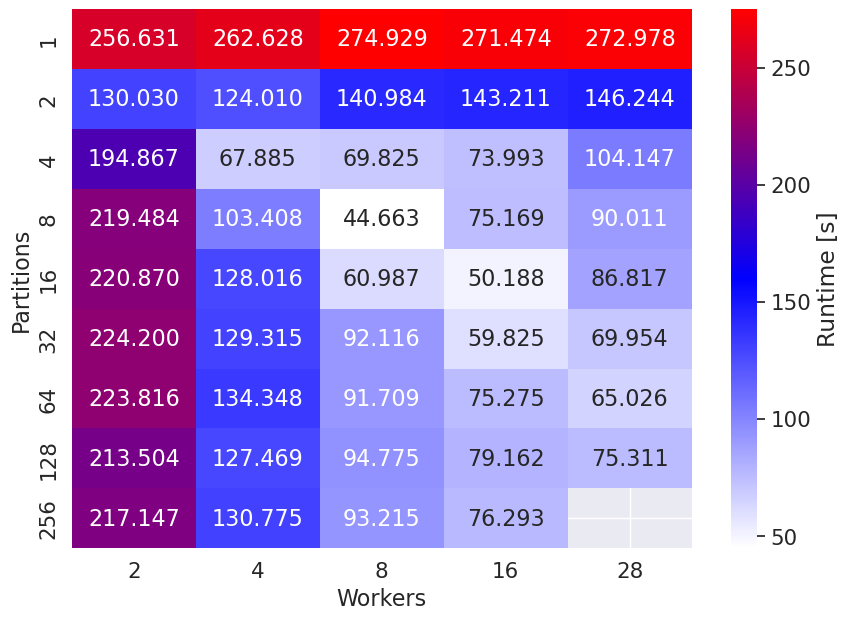

In [11]:
reshaped_durations = np.array(durations).reshape(len(npartitions), len(nworkers))
df_cm = pd.DataFrame(reshaped_durations, index=npartitions, columns=np.array(nworkers)*2)


# Plot the heatmap
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)  # for label size

# Define the custom color map from white to blue and then red
colors = ["white", "blue", "red"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".3f",
            cbar_kws={'label': 'Runtime [s]'}, cmap=cmap)
plt.xlabel('Workers', fontsize=16)
plt.ylabel('Partitions', fontsize=16)
plt.show()
plt.style.use('default')


In [22]:
client.close()
cluster.close()

In [23]:
client.shutdown()